In [1]:
import os
import torch
import numpy as np
import pickle
from PIL import Image
from torchvision import datasets, transforms

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Define data augmentation transformations
transform_aug = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Random horizontal flip
    transforms.RandomCrop(32, padding=4),  # Random crop with padding
    transforms.RandomRotation(15),  # Random rotation up to 15 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Random color adjustments
    transforms.ToTensor(),  # Convert image to Tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to range [-1, 1]
])

# Load CIFAR-10 data function (without augmentation)
def load_cifar10(data_dir):
    def load_batch(filename):
        with open(filename, 'rb') as f:
            batch = pickle.load(f, encoding='latin1')  # Load the batch
            data = batch['data'].reshape(-1, 3, 32, 32)  # Reshape data to (N, 3, 32, 32)
            labels = batch['labels']
            return data, labels

    train_data, train_labels = [], []
    for i in range(1, 6):
        d, l = load_batch(os.path.join(data_dir, f'data_batch_{i}'))
        train_data.append(d)
        train_labels.extend(l)
    
    # Concatenate all training data
    train_data = np.concatenate(train_data)
    train_labels = torch.tensor(train_labels)  # Convert labels to tensor

    # Load the test data
    test_data, test_labels = load_batch(os.path.join(data_dir, 'test_batch'))
    test_labels = torch.tensor(test_labels)

    # Convert the data to tensors and scale to [0, 1]
    train_data = torch.tensor(train_data, dtype=torch.float32) / 255.0
    test_data = torch.tensor(test_data, dtype=torch.float32) / 255.0

    # Apply normalization
    transform = transforms.Compose([
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the data
    ])
    
    train_data = transform(train_data)
    test_data = transform(test_data)

    return train_data, train_labels, test_data, test_labels

# Apply data augmentation to the training data and generate new images
def generate_images(train_data, train_labels, num_images=30000):
    augmented_images = []
    augmented_labels = []
    
    image_count = 0
    for img, label in zip(train_data, train_labels):
        # De-normalize the image (undo normalization: [-1, 1] to [0, 255])
        img = img * 255.0  # Scale from [-1, 1] to [0, 255]
        img = img.clamp(0, 255).byte()  # Ensure the values are in the correct range [0, 255] and convert to uint8
        
        # Convert tensor to PIL image for augmentation
        img_pil = Image.fromarray(img.permute(1, 2, 0).numpy())  # Convert tensor to PIL image
        
        # Apply augmentation
        augmented_img = transform_aug(img_pil)
        
        # Append the augmented image and label to lists
        augmented_images.append(augmented_img)
        augmented_labels.append(label)
        
        image_count += 1
        if image_count >= num_images:
            break
    
    # Convert augmented images and labels back to tensors
    augmented_images = torch.stack(augmented_images)  # Stack images into a batch tensor
    augmented_labels = torch.tensor(augmented_labels)  # Convert labels to tensor
    
    return augmented_images, augmented_labels


# Combine original and augmented data and save to disk
def save_data_aug(train_data, train_labels, augmented_images, augmented_labels, save_dir):
    combined_data = torch.cat((train_data, augmented_images), dim=0)
    combined_labels = torch.cat((train_labels, augmented_labels), dim=0)
    
    # Save combined data and labels
    augmented_data = {
        'data': combined_data.numpy(),
        'labels': combined_labels.numpy()
    }

    with open(os.path.join(save_dir, 'combined_data.pkl'), 'wb') as f:
        pickle.dump(augmented_data, f)
    
    print("Combined dataset saved to disk.")

# Load original CIFAR-10 dataset
data_dir = './data/cifar-10-batches-py'  # Ensure CIFAR-10 is downloaded here
train_data, train_labels, test_data, test_labels = load_cifar10(data_dir)

# Directory to save augmented images dataset
save_dir = '/home/user79/PJ/CIFAR-10/data/augmented_images'
os.makedirs(save_dir, exist_ok=True)

# Generate and save 25,000 augmented images
augmented_train_data, augmented_train_labels = generate_images(train_data, train_labels, num_images=25000)

# Combine original and augmented data and save to disk
save_data_aug(train_data, train_labels, augmented_train_data, augmented_train_labels, save_dir)

Combined dataset saved to disk.


In [2]:
# Directory to save augmented images dataset
save_dir = '/home/user79/PJ/CIFAR-10/data/augmented_images_2'
os.makedirs(save_dir, exist_ok=True)
# Generate and save 50,000 augmented images
augmented_train_data1, augmented_train_labels1 = generate_images(train_data, train_labels, num_images=50000)
# Combine original and augmented data and save to disk
save_data_aug(train_data, train_labels, augmented_train_data1, augmented_train_labels1, save_dir)

Combined dataset saved to disk.


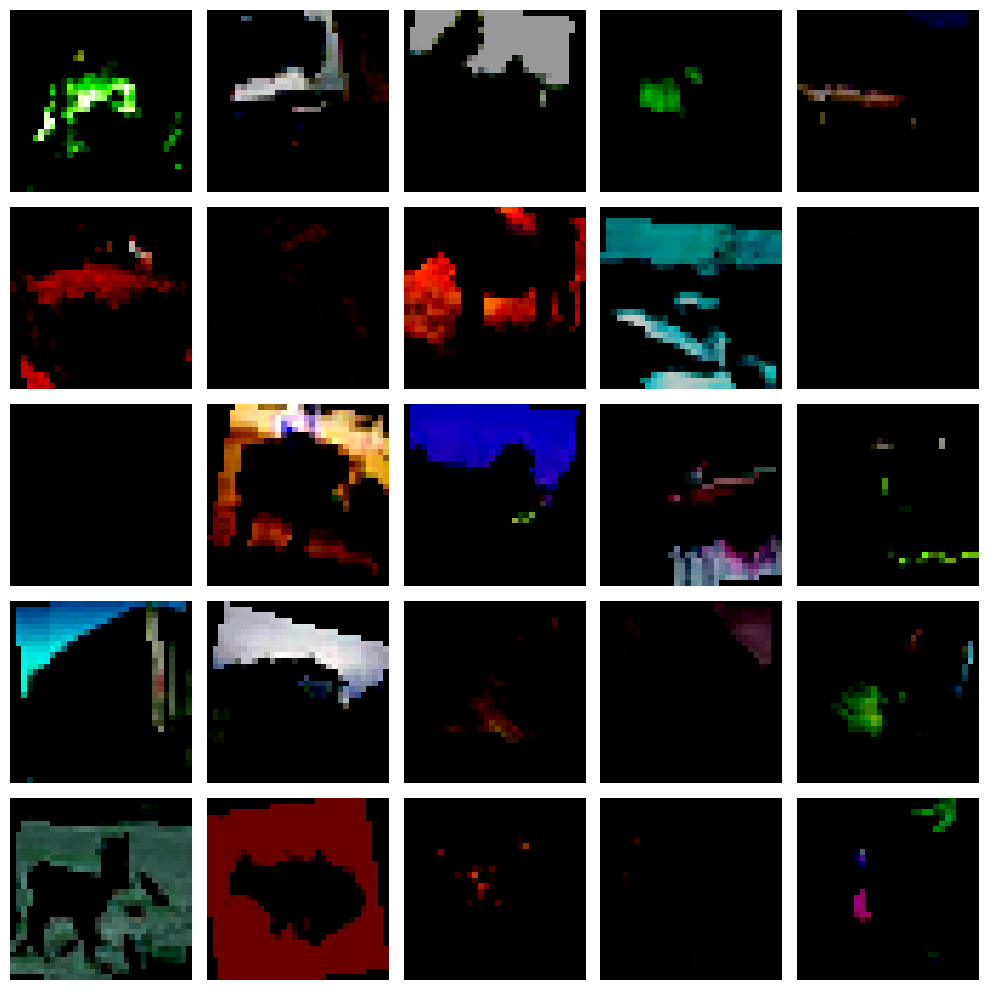

In [3]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_images(images):

    # Create a 5x5 grid to plot images
    fig, axes = plt.subplots(5, 5, figsize=(10, 10))
    
    for i, ax in enumerate(axes.flatten()):
        # Convert tensor to numpy and undo normalization
        img = images[i].permute(1, 2, 0).numpy()  # Convert tensor to (32, 32, 3) for plotting
        img = np.clip((img * 255), 0, 255).astype(np.uint8)  # De-normalize and convert to uint8
        
        # Plot the image
        ax.imshow(img)
        ax.axis('off')  # Turn off axis labels
    
    plt.tight_layout()
    plt.show()

# Visualize the first 25 images from the augmented images
visualize_images(augmented_train_data[:25])

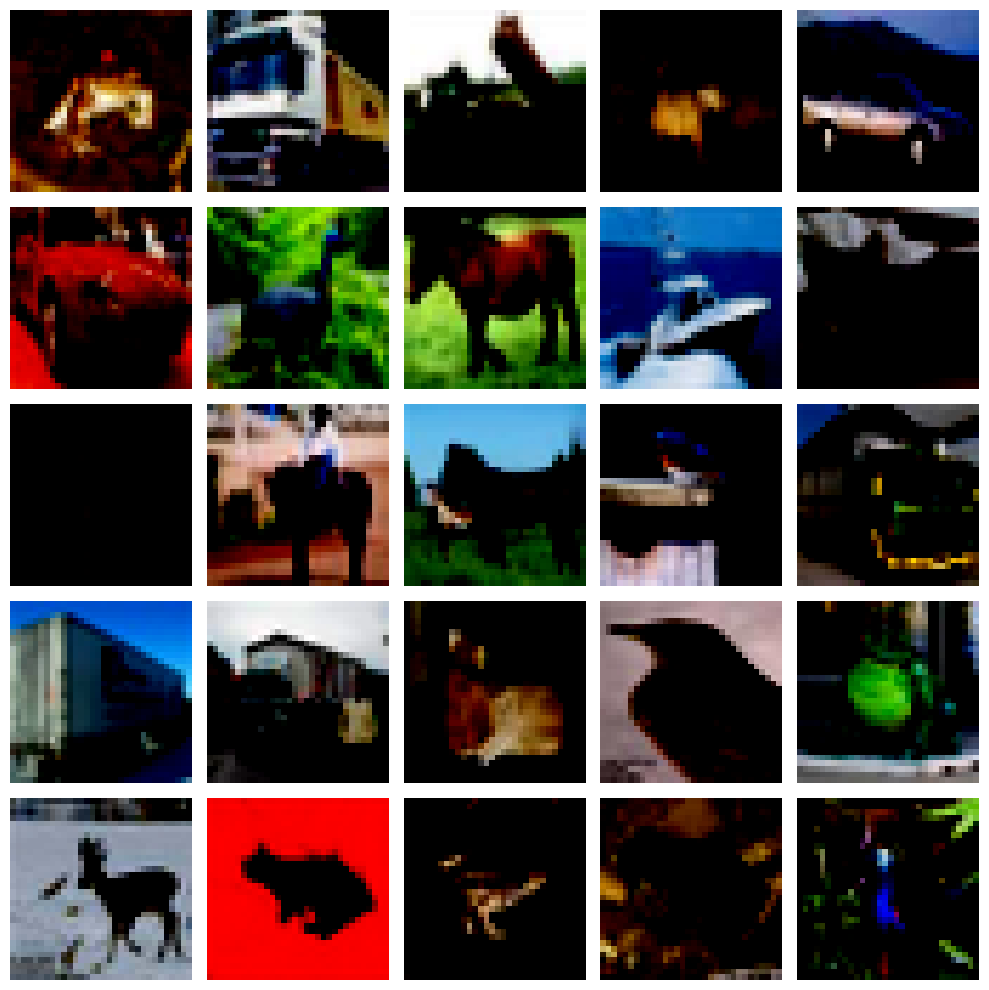

In [4]:
visualize_images(train_data[:25])

In [5]:
# Directory to save augmented images dataset
save_dir = '/home/user79/PJ/CIFAR-10/data/augmented_images_3'
os.makedirs(save_dir, exist_ok=True)
# Generate and save 100,000 augmented images
augmented_train_data2, augmented_train_labels2 = generate_images(train_data, train_labels, num_images=50000)
augmented_train_data3, augmented_train_labels3 = generate_images(train_data, train_labels, num_images=50000)

In [7]:
combined_data = torch.cat((augmented_train_data1, augmented_train_data2), dim=0)
combined_data = torch.cat((combined_data, augmented_train_data3), dim=0)
combined_labels = torch.cat((augmented_train_labels1, augmented_train_labels2), dim=0)
combined_labels = torch.cat((combined_labels, augmented_train_labels3), dim=0)
# Combine original and augmented data and save to disk
save_data_aug(train_data, train_labels, combined_data, combined_labels, save_dir)

Combined dataset saved to disk.


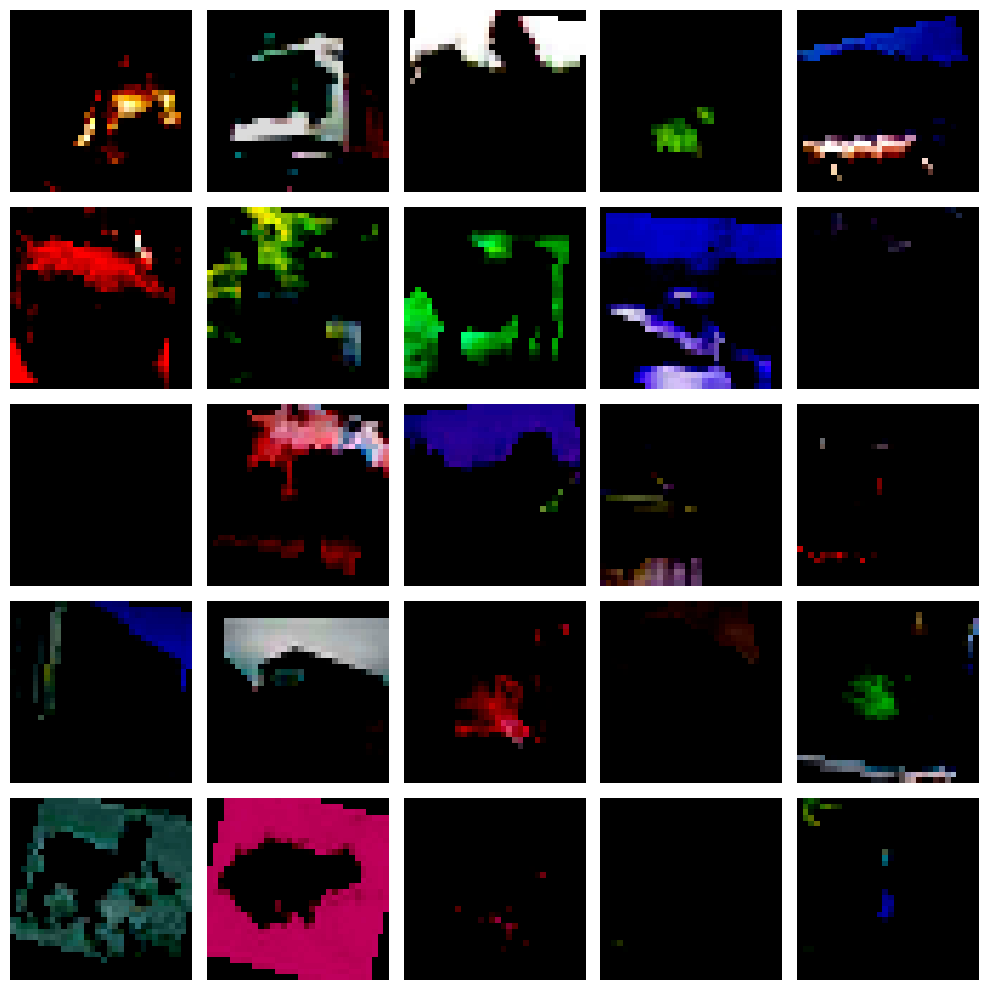

In [6]:
visualize_images(augmented_train_data1[:25])

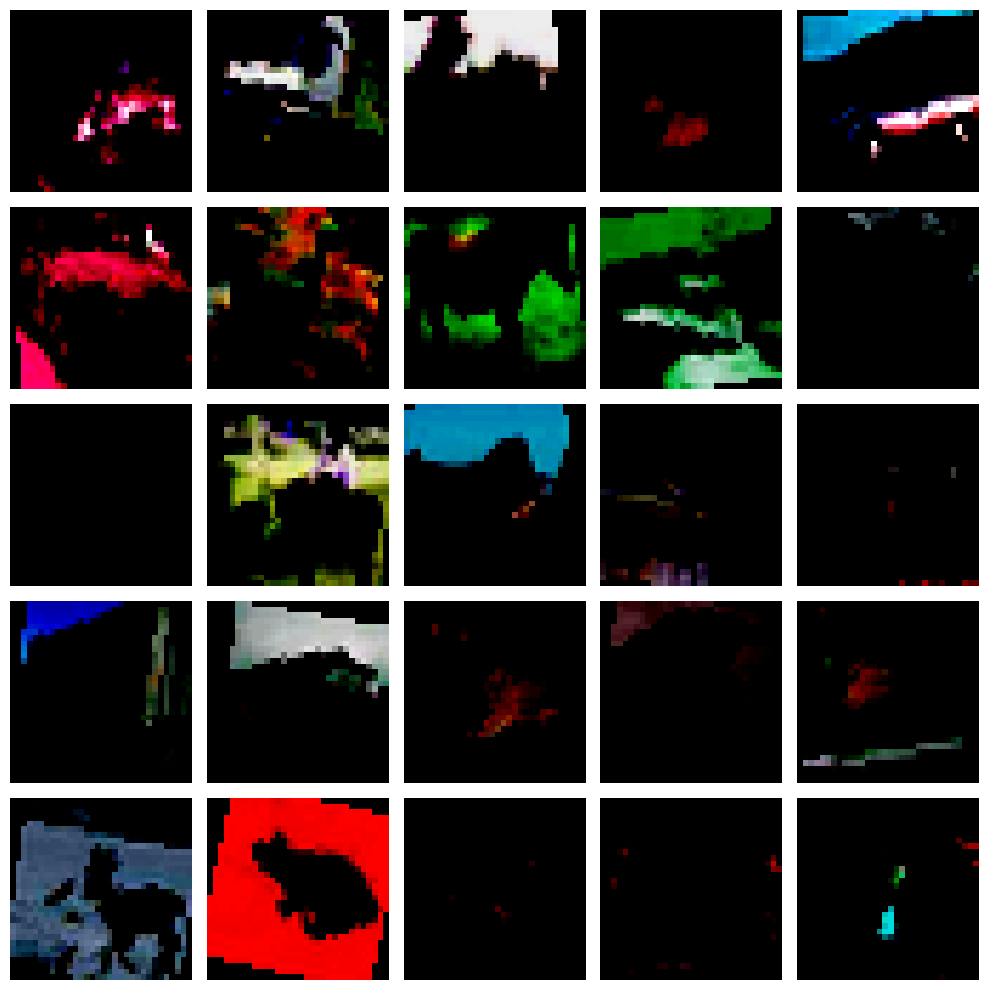

In [8]:
visualize_images(augmented_train_data2[:25])